# TVLA, DL-LA on AISy Lab data

Datasets are:

1. `aes_tvla.h5` full AES encryption, traces were compressed from 220000 to 22000 samples.
2. `aes_tvla_round5.h5` AES round 5, without compression.
3. `aes_tvla_ttables.h5` full AES encryption, without compression.

to read the files, you can use the following code:

In [4]:
import h5py
import numpy as np
import seaborn as sns
from scipy.special import comb
from scipy.stats import norm
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.optimizer_v2.adam import Adam
from tensorflow.python.keras.utils.np_utils import to_categorical
from tqdm import tqdm
import matplotlib.pyplot as plt

from src.data.loaders import aisy
from src.dlla.hw import p_gradient_dl_la, dlla_hw
from src.tools.cache import cache_np

from src.tools.plotter import plot_p_gradient
from src.tvla.accu import TvlaAccu

from src.data.preprocess.hw import full_states

def large_figure():
    plt.figure(figsize=(9, 6))

In [5]:
from src.tvla.t import make_t_test

in_file = h5py.File(aisy.aes.tvla_ttables, "r")
TRACES = np.array(in_file['traces_group/traces'], dtype=np.int8)
TVLA_BYTE = in_file['traces_group/metadata']['tvla_byte'].astype(bool)[:, 0]
PLAINTEXT = in_file['traces_group/metadata']['plaintext'].astype(int)
CIPHERTEXT = in_file['traces_group/metadata']['ciphertext'].astype(int)
KEY = in_file['traces_group/metadata']['key'].astype(int)

sns.set_style('whitegrid')

As you can see, you have tvla_byte, which indicates if a trace has low Hamming weight in round 5 (I believe after s-box)
or simply random data. To generate a low HW state in round5, a chosen-plaintext is generated by doing a backpass in AES
encryption. But these are just details, you don't have to worry about it now.

You can split traces into groups A and B (of approx 5k traces each) by considering this tvla_byte.

In [6]:
TRACES.shape

(10000, 22000)

In [7]:
np.min(TRACES), np.max(TRACES)

(-128, 127)

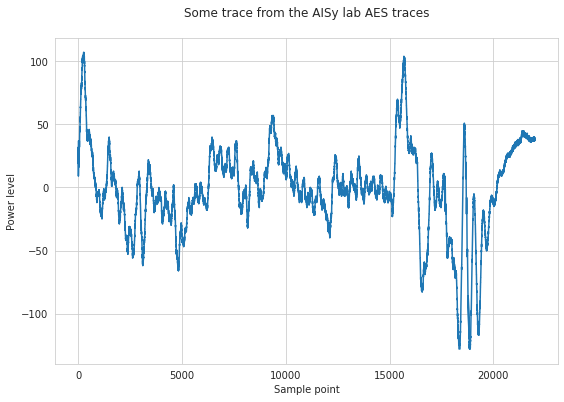

In [8]:
large_figure()
G = sns.lineplot(data=TRACES[0])
G.set(ylabel="Power level", xlabel="Sample point", title="Some trace from the AISy lab AES traces\n") and None

## TVLA

With 2 class evaluation. Method of the DL-LA paper.

In [9]:
# A: Low HW
A5 = TRACES[TVLA_BYTE]
# B: Random data
B5 = TRACES[np.invert(TVLA_BYTE)]

In [10]:
def random_split(x, fraction):
    """
    Splits the given array in two parts.
    - the first part is approximately of size n * (1 - fraction).
    - the second part is approximately of size n * fraction.
    """
    selection = np.random.random(len(x)) > fraction

    return x[selection], x[np.invert(selection)]

def random_divide(x):
    """
    Divides the given array in two equally sized parts.
    """
    left, right = random_split(x, .5)
    res_size = min(len(left), len(right))

    return left[:res_size], right[:res_size]

In [11]:
def mdiff(a, b):
    """
    Calculates the moment difference for all sample points,
    a predictive measure for the performance of an 1st order t-test.
    """
    def get_moment(x: np.array):
        return x.mean(axis=0, dtype=np.float128)

    a1, a2 = random_divide(a)
    _, b2 = random_divide(b)

    mdiff_in = np.abs(get_moment(a1) - get_moment(a2))
    mdiff_out = np.abs(get_moment(a1) - get_moment(b2))

    return mdiff_out - mdiff_in

MDIFF = mdiff(A5, B5)

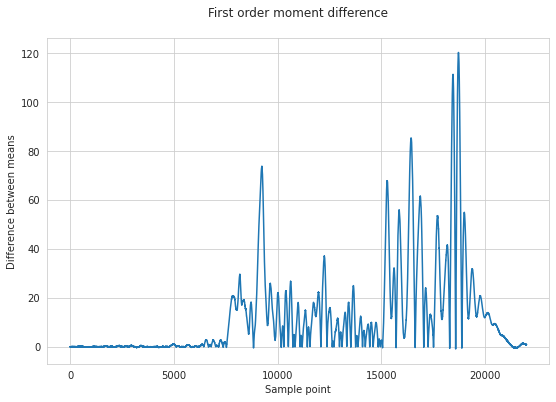

In [12]:
large_figure()
G = sns.lineplot(data=MDIFF)
G.set(ylabel="Difference between means", xlabel="Sample point", title="First order moment difference\n") and None

In [13]:
TITLE = "A: Low hamming weight, B: Random\n"
MAX_TRACES = 125

def min_p_gradient(a, b):
    """
    Calculates the min p-gradient for the t-test of two data sets.
    """
    accumulator = TvlaAccu(a.shape[1], make_test=make_t_test)
    accumulator.add(a, b)

    return accumulator.p_gradient

P_GRADIENT_AB = cache_np('aisy/p_gradient_ab', min_p_gradient, A5, B5)
P_GRADIENT_BB = cache_np('aisy/p_gradient_bb', min_p_gradient, *random_divide(B5))

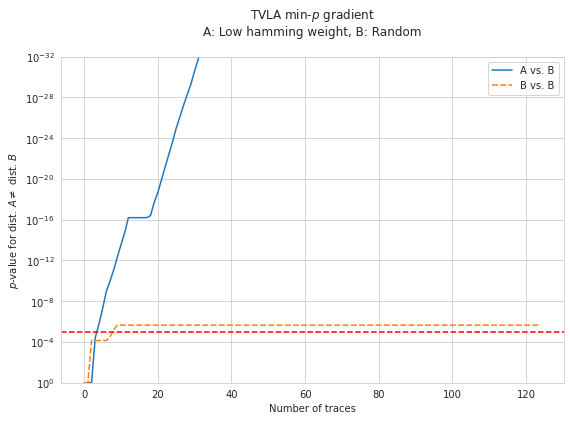

In [14]:
large_figure()
plot_p_gradient({"A vs. B": P_GRADIENT_AB, "B vs. B": P_GRADIENT_BB}, f"TVLA min-$p$ gradient\n{TITLE}", MAX_TRACES)

## 2-class training

With 2 class evaluation

In [15]:
NUM_CLASSES = 2
TRACE_LEN = A5.shape[1]

def make_mlp_paper(x, y, x_attack, y_attack, trace_len=TRACE_LEN):
    mdl = Sequential()
    mdl.add(Dense(120, activation='relu', input_shape=(trace_len,)))
    mdl.add(Dense(90, activation='relu'))
    mdl.add(Dense(50, activation='relu'))
    mdl.add(Dense(2, activation='softmax'))

    mdl.compile(optimizer=Adam(lr=0.001), loss='mse', metrics='accuracy')

    mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=150,
                  epochs=5, verbose=True)

    return mdl

In [16]:
def z_norm(x_profiling, x_attack):
    profiling_mean, profiling_var = x_profiling.mean(axis=0), x_profiling.var(axis=0)

    def normalize(x):
        return (x - profiling_mean) / profiling_var

    return normalize(x_profiling), normalize(x_attack)


def concat(arrays: np.array):
    return np.concatenate(arrays, axis=0)

def labelize(class_traces):
    """
    Labels the provided traces.
    class_traces should be an array of trace groups. Each group gets labelled with it's index.
    So the first group gets label 0, the second label 1, etc.

    Returns the Concatenates the traces and one
    """
    num_classes = len(class_traces)

    res = []
    for cls, traces in enumerate(class_traces):
        res.append([cls] * len(traces))

    return concat(class_traces), concat(res), num_classes

# Percentage of traces that will go in the attack trace set.
ATTACK_RATIO = .2

def prepare_dlla(traces, labels, num_classes):
    """
    Prepares traces for usage in DL-LA training.
    """
    # Randomize traces and labels
    indices = np.arange(len(traces))
    np.random.shuffle(indices)
    x, y = traces[indices], labels[indices]

    # Separate attack from profiling traces
    num_profiling = round(1 - ATTACK_RATIO * len(traces))
    x_profiling, x_attack = x[:num_profiling], x[num_profiling:]
    y_profiling, y_attack = y[:num_profiling], y[num_profiling:]

    # Normalize traces
    x_profiling, x_attack = z_norm(x_profiling, x_attack)

    # One-hot encode labels
    y_profiling, y_attack = to_categorical(y_profiling, num_classes), to_categorical(y_attack, num_classes)

    return x_profiling, y_profiling, x_attack, y_attack

In [17]:
AB_DLLA_PAPER = prepare_dlla(*labelize((A5, B5)))
MODEL_AB = make_mlp_paper(*AB_DLLA_PAPER)

Epoch 1/5
54/54 [==============================] - 1s 19ms/step - loss: 0.0290 - accuracy: 0.9549 - val_loss: 0.0011 - val_accuracy: 0.9990

In [18]:
BB_DLLA_PAPER = prepare_dlla(*labelize(random_divide(B5)))
MODEL_BB = make_mlp_paper(*BB_DLLA_PAPER)

Epoch 1/5
27/27 [==============================] - 1s 21ms/step - loss: 0.2645 - accuracy: 0.5096 - val_loss: 0.2656 - val_accuracy: 0.5040
Epoch 2/5
27/27 [==============================] - 1s 22ms/step - loss: 0.2232 - accuracy: 0.6416 - val_loss: 0.2685 - val_accuracy: 0.5433

## Test statistic from DL-LA paper

Using the binomial test described in the paper. Above 1000 traces, the binomial coefficient from the binomial
test goes to $+\inf$. Therefore, I added a $Z$-test which takes over in these cases. A $Z$-test is an approximation for
the binomial test, and is accurate for a large sample set.

In [19]:
def z_test(validation_size, num_correct):
    """
    Approximation of a binomial test with success probability = 0.5.
    This simple version of the Z-test is accurate only for large sample sizes.
    """
    z_score = (num_correct - validation_size * .5) / np.sqrt(validation_size * .25)

    return norm.cdf(-z_score)

def binomial_test(validation_size, num_correct):
    """
    Binomial test with success probability = 0.5.
    Returns the p-value for hypotheses H0: validation accuracy ≤ 0.5,
        where the validation accuracy is calculated by (num_correct / validation_size).

    - validation_size refers to M from the DL-LA paper.
    - num_correct refers to s_M from the DL-LA paper.
    """
    p = 0
    for k in range(num_correct, validation_size + 1):
        # Binomial coefficient
        c = comb(validation_size, k)

        if c > 10 ** 32:
            # If the validation size is large (more than 1000 traces) p tends to go to infinite.
            # In this case, approximate the binomial test using z-test.
            return z_test(validation_size, num_correct)

        p += c

    p_value = p * .5 ** validation_size

    return p_value

def dlla_p_gradient_paper(model: Model, x_attack: np.array, y_attack: np.array):
    """
    Retrieves a p-gradient from applying the trained model on the attack trace set.
    """
    total = 0
    total_correct = 0
    res = []

    for x, y in zip(model.predict(x_attack), y_attack):
        total += 1
        total_correct += x.argmax() == y.argmax()
        res.append(binomial_test(total, total_correct))

    return np.array(res)

In [20]:
AB_PG_PAPER = dlla_p_gradient_paper(MODEL_AB, *AB_DLLA_PAPER[2:])
BB_PG_PAPER = dlla_p_gradient_paper(MODEL_BB, *BB_DLLA_PAPER[2:])

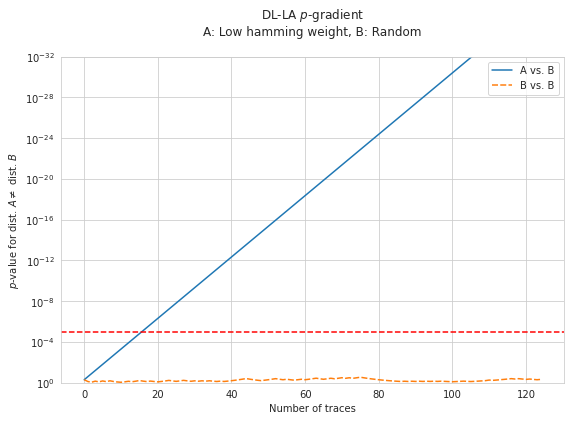

In [21]:
large_figure()
plot_p_gradient({"A vs. B": AB_PG_PAPER, "B vs. B": BB_PG_PAPER}, f"DL-LA $p$-gradient\n{TITLE}", MAX_TRACES)

## 9-class training

With 2 class evaluation

In [22]:
def hw_byte(plaintexts: np.array, keys: np.array, aes_round=4, target_byte=2):
    """
    Returns the hamming weight of the AES state at the given round and target byte indices.
    """
    states = full_states(plaintexts, keys)

    return states[:, aes_round, target_byte]

HAMMING_WEIGHTS = cache_np(F'aisy/hw_r5_b3', hw_byte, PLAINTEXT, KEY)

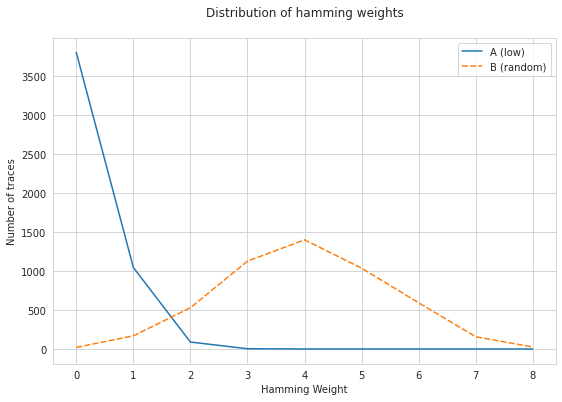

In [23]:
large_figure()
G = sns.lineplot(data={
    "A (low)": np.bincount(HAMMING_WEIGHTS[TVLA_BYTE], minlength=9),
    "B (random)": np.bincount(HAMMING_WEIGHTS[np.invert(TVLA_BYTE)], minlength=9)
})
G.set(title="Distribution of hamming weights\n", xlabel="Hamming Weight", ylabel="Number of traces") and None

In [24]:
def prepare_dlla_9cls(traces, hamming_weights):
    """
    Prepares traces for usage in 9 class training.
    """
    ab = prepare_dlla(traces, hamming_weights, 9)

    hws_random = hamming_weights.copy()
    np.random.shuffle(hws_random)
    bb = prepare_dlla(traces, hws_random, 9)

    return ab, bb

AB_DLLA, BB_DLLA = prepare_dlla_9cls(TRACES, HAMMING_WEIGHTS)

In [25]:
def make_mlp(x, y, x_attack, y_attack):
    mdl = Sequential()
    mdl.add(Dense(100, activation='relu', input_shape=(TRACE_LEN,)))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(100, activation='relu'))
    mdl.add(Dense(9, activation='softmax'))

    mdl.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics='accuracy')

    out = mdl.fit(x, y, shuffle=True, validation_data=(x_attack, y_attack), batch_size=150,
                  epochs=1, verbose=True)

    return out, mdl

In [26]:
MODEL_AB = make_mlp(*AB_DLLA)
MODEL_BB = make_mlp(*BB_DLLA)

54/54 [==============================] - 1s 19ms/step - loss: 1.9428 - accuracy: 0.3482 - val_loss: 1.8576 - val_accuracy: 0.3767

In [27]:
dlla_hw(MODEL_AB, *AB_DLLA[2:])

(7.597954527857501e-202, 0.6702867871041124)

In [28]:
def dlla_p_gradient(model, x_attack, y_attack):
    """
    Converts the output (pandas DataFrame) of the p-gradient intermediate DL-LA step into
        the same p-gradient as displayed elsewhere in this notebook.
    """
    df = p_gradient_dl_la(model, x_attack, y_attack, len(x_attack))
    df = df[df.columns[0]]
    num_traces = max(df.index)

    pv = 1
    acc = np.zeros(num_traces)

    for ix in range(num_traces):
        if ix in df.index:
            pv = df.loc[ix]

        acc[ix] = pv

    return acc

AB_PG = dlla_p_gradient(MODEL_AB, *AB_DLLA[2:])
BB_PG = dlla_p_gradient(MODEL_BB, *BB_DLLA[2:])

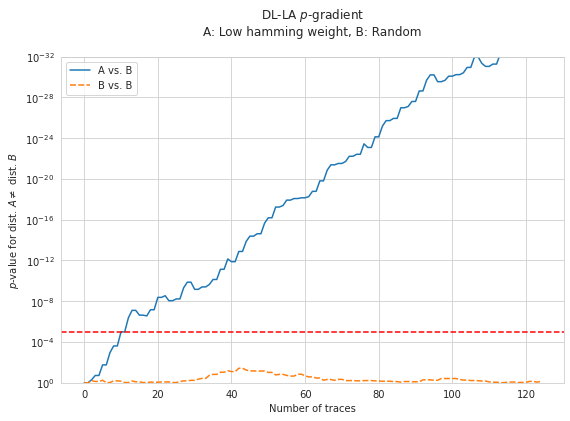

In [29]:
large_figure()
plot_p_gradient({"A vs. B": AB_PG, "B vs. B": BB_PG}, f"DL-LA $p$-gradient\n{TITLE}", MAX_TRACES)

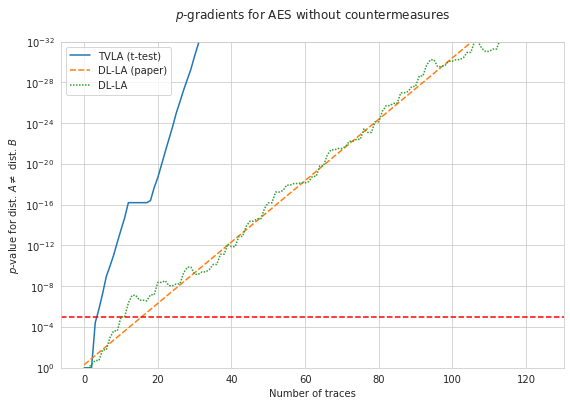

In [30]:
large_figure()
plot_p_gradient({"TVLA (t-test)": P_GRADIENT_AB, "DL-LA (paper)": AB_PG_PAPER, "DL-LA": AB_PG},
                f"$p$-gradients for AES without countermeasures\n", MAX_TRACES)

## Desync traces

In [31]:
def ascad_desync(raw_traces, target_points, max_desync):
    """
    Trace desynchronization, adapted from the ASCAD desynchronization method.
    """
    num_traces = len(raw_traces)

    diff = np.ediff1d(target_points)
    consecutive_indices = np.split(target_points, np.where(diff !=1)[0]+1)

    desync_traces = np.zeros([num_traces, len(target_points)], target_points.dtype)

    curr_trace = 0
    for ix in tqdm(range(num_traces)):
        r_desync = np.random.randint(max_desync)

        curr_point = 0
        for cons_chunk in consecutive_indices:
            chunk = raw_traces[ix,cons_chunk[0]+r_desync:cons_chunk[len(cons_chunk)-1]+r_desync+1]
            desync_traces[curr_trace,curr_point:curr_point+len(cons_chunk)] = chunk
            curr_point += len(cons_chunk)
        curr_trace += 1

    return desync_traces

def simple_desync(traces, max_desync):
    """
    Simplified trace desynchronization.

    Limits the trace size to trace_size - max_desync, because there is no data surrounding
        the trace for the provided database.
    """
    if max_desync <= 0:
        return traces

    num_traces = len(traces)
    desync_traces = np.zeros(traces[:, max_desync:].shape)
    desync = np.random.randint(0, max_desync, size=num_traces)

    for ix in tqdm(range(num_traces), desc="Desynchronizing traces"):
        move = desync[ix]
        desync_traces[ix] = traces[ix][move:-(max_desync - move)]

    return desync_traces

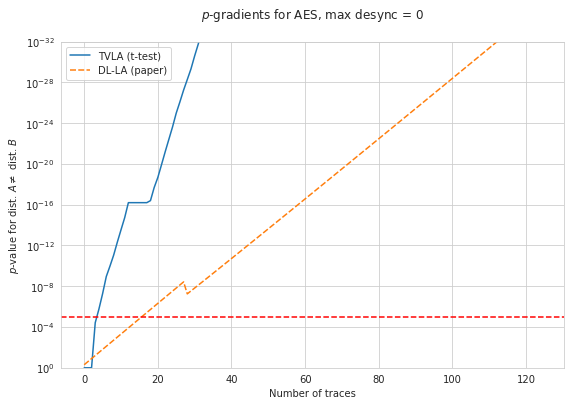

Desynchronizing traces: 100%|██████████| 5057/5057 [00:00<00:00, 16875.08it/s]


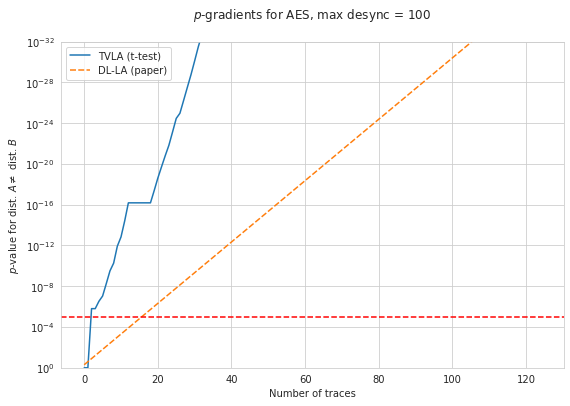

Desynchronizing traces: 100%|██████████| 5057/5057 [00:00<00:00, 17659.79it/s]


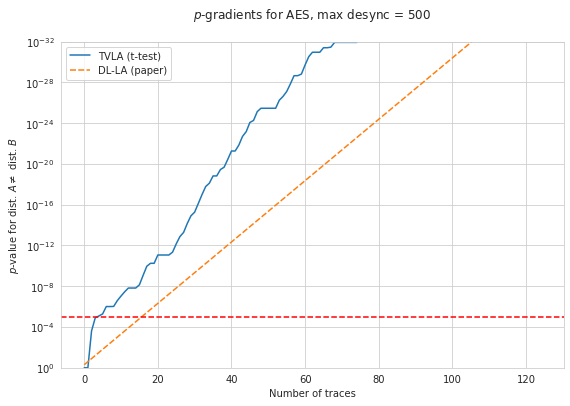

Desynchronizing traces: 100%|██████████| 5057/5057 [00:00<00:00, 18605.83it/s]


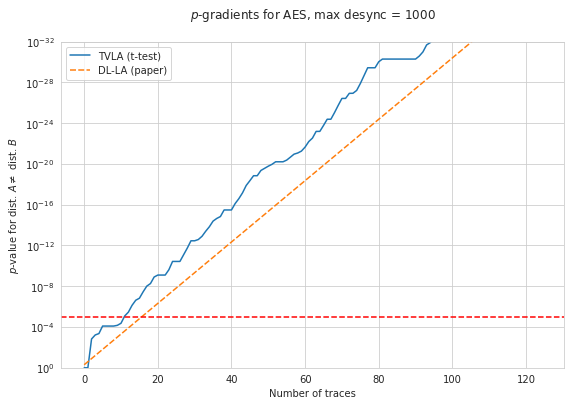

Desynchronizing traces: 100%|██████████| 5057/5057 [00:00<00:00, 18324.95it/s]


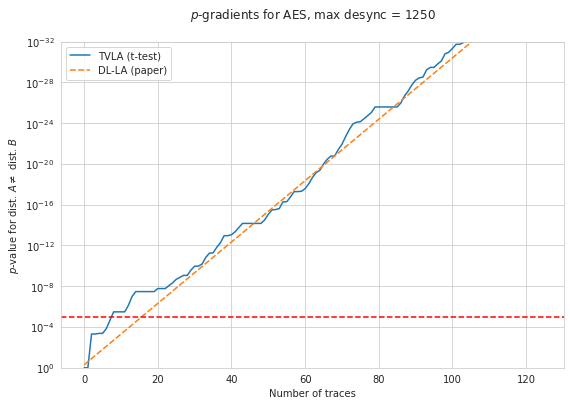

Desynchronizing traces: 100%|██████████| 5057/5057 [00:00<00:00, 19181.22it/s]


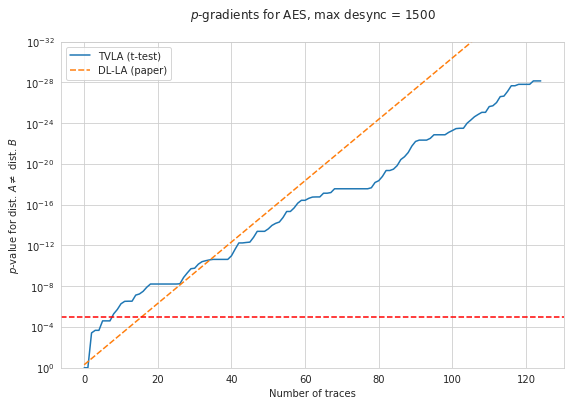

In [32]:
def p_gradient_paper(a, b):
    """
    Labels and z-normalizes traces, trains a MLP (as shown in the DL-LA paper).
    Returns the p-gradient for the attack traces
    """
    dlla_traces = prepare_dlla(*labelize((a, b)))
    dlla_model = make_mlp_paper(*dlla_traces, trace_len=a.shape[1])

    return dlla_p_gradient_paper(dlla_model, *dlla_traces[2:])

In [ ]:
def compare_desync(a, b):
    """
    Compare TVLA to DLLA on different levels of trace desynchronization.
    """
    for desync in [0, 100, 500, 1000, 1250, 1500]:
        a_desync, b_desync = simple_desync(a, desync), simple_desync(b, desync)

        name = f"aisy/desync/{desync}"
        tvla = cache_np(f"{name}/tvla", min_p_gradient, a_desync, b_desync)
        dlla = cache_np(f"{name}/dlla", p_gradient_paper, a_desync, b_desync)
        
        large_figure()
        plot_p_gradient({"TVLA (t-test)": tvla, "DL-LA (paper)": dlla},
                    f"$p$-gradients for AES, max desync = {desync}\n", MAX_TRACES)

compare_desync(A5, B5)

## Simulate jitter

Simulates jitter by randomly and independently shifting sample points a few positions to the left and right.
Random shift is modelled by a normal distribution with mean $\mu = 0$ and a given value for the variance $\sigma$.

In [33]:
def jitter_trace(trace, variance=2):
    """
    Simulates jitter by randomly and independently shifting sample points a few positions to the left and right.
    Random shift is modelled by a normal distribution with mean 0 and a given value for the variance.
    """
    trace_len = len(trace)
    shift = np.random.normal(0, scale=variance, size=trace_len).astype(int)

    res = trace.copy()
    for ix, move in zip(range(trace_len), shift):
        if move == 0:
            continue

        new_ix = min(trace_len - 1, max(0, ix + move))
        val = res[ix]

        move_left = int(ix < new_ix)
        shift_ixs = np.arange(min(ix, new_ix), max(ix, new_ix)) + move_left
        res[shift_ixs + 1 - (2 * move_left)] = res[shift_ixs]

        res[new_ix] = val

    return res

assert np.all(np.bincount(jitter_trace(TRACES[0]) + 128) == np.bincount(TRACES[0] + 128))

In [34]:
def jitter(traces, variance=2):
    """
    Simulates jitter using the given level of variance. Applies it to the supplied traces.
    """
    res = np.zeros_like(traces)
    for ix in tqdm(range(len(traces)), desc="Applying jitter"):
        res[ix] = jitter_trace(traces[ix], variance)

    return res

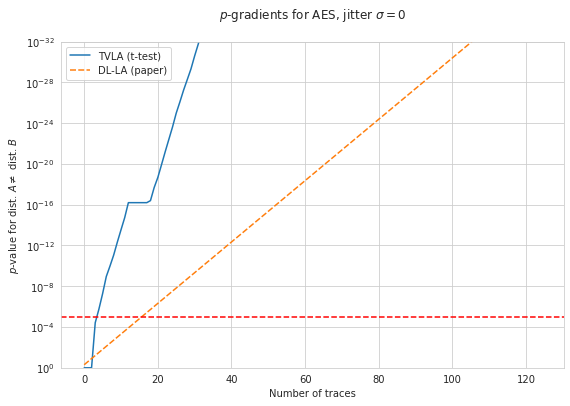

Running t-tests:   0%|          | 0/1646 [00:00<?, ?it/s]/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:25: RuntimeWarning: divide by zero encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:25: RuntimeWarning: invalid value encountered in true_divide
  t = m / s
/home/berg/Documents/Afstudeer/LA/src/tvla/t.py:27: RuntimeWarning: invalid value encountered in true_divide
  dof = (var_a + var_b) ** 2 / ((var_a ** 2 + var_b ** 2) / nmm)
Running t-tests: 100%|██████████| 1648/1648 [00:08<00:00, 202.66it/s]


Epoch 1/5
54/54 [==============================] - 1s 22ms/step - loss: 0.0316 - accuracy: 0.9600 - val_loss: 2.8330e-05 - val_accuracy: 1.0000

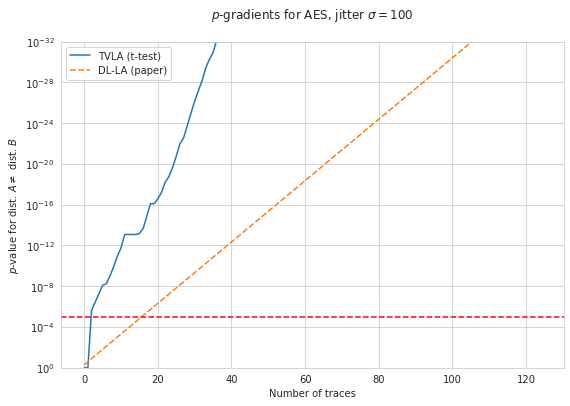

In [62]:
def compare_jitter(a, b):
    """
    Compare TVLA to DLLA on different levels of jitter Variance.
    """
    for variance in [0, 100]:
        name = f"aisy/jitter/{variance}"

        if variance > 0:
            a_jitter = cache_np(f"{name}/a5", jitter, a, variance)
            b_jitter = cache_np(f"{name}/b5", jitter, b, variance)
        else:
            a_jitter, b_jitter = a, b

        tvla = cache_np(f"{name}/tvla", min_p_gradient, a_jitter, b_jitter)
        dlla = cache_np(f"{name}/dlla", p_gradient_paper, a_jitter, b_jitter)

        large_figure()
        plot_p_gradient({"TVLA (t-test)": tvla, "DL-LA (paper)": dlla},
                    f"$p$-gradients for AES, jitter $\sigma = {variance}$\n", MAX_TRACES)

compare_jitter(A5, B5)

Applying jitter: 100%|██████████| 1/1 [00:00<00:00,  6.84it/s]


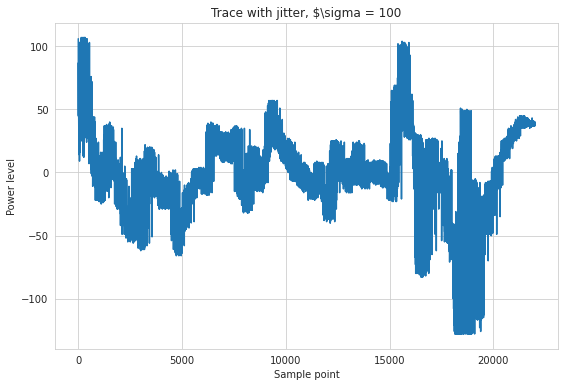

In [65]:
large_figure()
G = sns.lineplot(data=jitter([TRACES[0]], 100)[0])
G.set(title="Trace with jitter, $\sigma = 100", ylabel="Power level", xlabel="Sample point") and None

<AxesSubplot:>

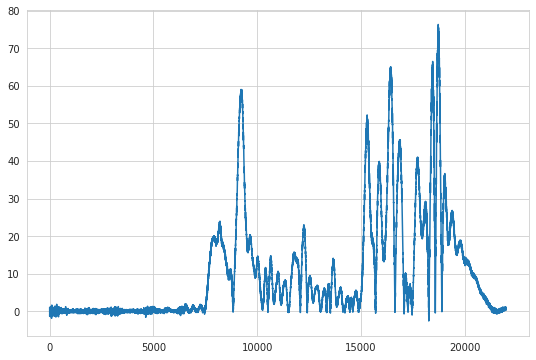

In [64]:
large_figure()
sns.lineplot(data=mdiff(cache_np(f"aisy/jitter/100/a5"), cache_np(f"aisy/jitter/100/b5")))
# sns.lineplot(data=mdiff(A5, B5))